# Efficient training of neural networks

In the previous notebook, we outlined the ability of neural networks to solve a large variety of tasks. Specifically, we demonstrated that neural networks can be used for image classification and for predicting complex biological processes, such as the conductance of nerve membranes. The main reason for this verstility of neural networks is two-fold: 
1. neural networks are universal function approximators, meaning they can learn any function from data; and 
2. surprisingly many tasks can be approximated as input-output relationships, i.e. functions. 

For example, we saw that digit classification can be achieved by learning a probability density function, $p(y | x)$, where $x$ denotes the pixels in the image, and $y$ denotes the digit. In this notebook, we dive deeper into some of the challenges of learning functions from data -- challenges that are important to understand when modelling language with neural networks.

**Learning outcomes:**

1. An intuitive understanding of architectural choices for neural networks
2. An understanding of the limitations of neural networks when learning functions from data
3. The value of prior knowledge for more efficient learning and better generalisation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import kai

## 1 Using neural networks for language processing

The universal function approximation theorem states that multi-layer perceptrons (MLPs) can approximate any function, provided they have sufficiently many artificial neurons. This makes it possible to learn any function from data using neural networks. At this point, you might start to wonder what all of this has to do with natural language processing and large language models... After all, language seems to be quite different from simple input-output relationships, making it hard to imagine how the universality of neural networks helps with processing language.

But how different is language from an input-output relationship really? If we think, for example, about chatbots like our very own Equinor AIChat, typical interactions with the chatbot often take the form of questions (inputs) and answers (outputs): We ask a question or make a statement; and the chatpot replies. Hmm, so perhaps some elements of language can be interpreted as an input-output relationship after all!

That's exciting! Let us try to develop a neural network that can answer questions.

### Task 1: Brainstorm how you could use an MLP to answer questions

Assume for now that we have a fixed number of questions that can be asked and that also the number of answers to each question is fixed. What could the inputs to the network represent? What would the outputs be?

You can document your thoughts here:

The challenge of processing language using neural network is that neural networks can only process and output numerical values. We therefore need to map questions and answers to numerical values. A naïve approach to achieve this for a fixed number of questions and answers is to enumerate the questions and the answers. The question ID can then be used as an input to the neural network and the output of the neural network would be either the corresponding answer ID, or, if we want to capture the possibility of multiple answers, a probability mass function over the answer IDs. 

### Task 2: What are the limitations of the Q&A MLP?

After making an initial attempt to define suitable inputs and outputs to the Q&A neural network, have a look at some example questions and answers below. Do you foresee any challenges with answering questions? Think especially about how well your model might answer questions that it has not seen before, or even how it might answer questions that only use a slightly different wording than those in the datatset. 

*Tipp:* If you struggle to see the limitations of your Q&A neural network, let us try it! Create a code cell below this one and use the Q&A data to train an MLP. You can copy the neural network definition and the training script from the previous notebook. For simplicity, you could just focus on the first 50 questions and answers in the dataset and use the ``nn.CrossEntropyLoss()`` as an objective for the training. Remember to split your dataset into a training and into a test dataset to test your model on unseen questions. How well can your model answer the questions?

In [2]:
data = kai.get_qa_datatset()

print(data[0])
print('')
print(data[30])
print('')
print(data[42])

{'qId': 'wqr000001', 'answers': ['Padmé Amidala'], 'question': 'what character did natalie portman play in star wars?'}

{'qId': 'wqr000567', 'answers': ['Apollo 13', 'A Beautiful Mind', 'Curious George', 'Happy Days', 'Cocoon', 'From the Earth to the Moon'], 'question': 'what movies did ron howard do?'}

{'qId': 'wqr000718', 'answers': ['Alan Ruck'], 'question': "who plays ferris bueller's best friend?"}


Ok, it's obvious that the Equinor AIChat does not use our simple Q&A neural network approach! While we can enumerate questions and answers, and train a neural network to remember the mapping between them, it does not actually allow the neural network to answer any questions that are not identical to the training questions. In fact, by enumerating questions and answers, we abstract away any logic or knowledge contained within them that a human might infer to answer unseen, related questions.

Note that, in principle, our Q&A neural network *can* answer any questions provided they are contained in the training data. It simply cannot make any inferences or generalise beyond the training questions and answers in its current formulation. 

## 2 Universal, but not generalisable

The challenges of using MLPs for learning function approximations that generalise beyond the training data are not unique to language processing. In fact, the first approach to improve the generalisability of neural networks comes from image classification. This advancement ultimately led to the development of the LLM neural networks that we are using today. We will therefore focus in this notebook on understanding this approach.

To begin, let us revisit the MNIST image classification challenge that we have worked on in the previous notebook. Below we have defined the MLP for the image classification. The only new element to the previous notebook is that we have slighly increased the size of the images by padding the space around the digits (see cell below). 

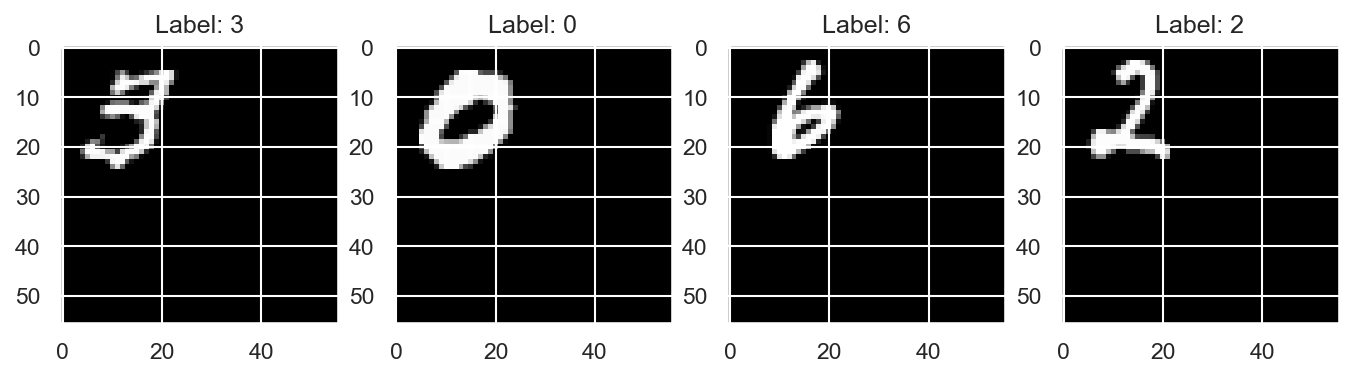

In [2]:
# Load data
train_loader, test_loader1, test_loader2 = kai.get_modified_mnist_data()

# Get a batch of images and labels
images, labels = next(iter(train_loader))

kai.plot_images(images, labels)

### Task 3: Train the neural network on the new dataset

In [3]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Set up training
input_size = 784 * 4
num_classes = 10
learning_rate = 0.001
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Network
model = NeuralNetwork(input_size=input_size, num_classes=num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
kai.train_mnist_model(
    num_epochs, model, criterion, optimizer, train_loader, device)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


### Task 4: Check that the accuracy on the training data is still the same

In [5]:
print('Accuracy on training data:')
kai.check_accuracy(train_loader, model, device)

Accuracy on training data:
Got 58393/60000 with accuracy  97.32


Amazing! The padding of the images had no effect on the accuracy -- and why would it? The digits in the images remain the same, whether there is black space around them or not.

### Task 5: Evaluate the accuracy of the model on the two test datasets
The test datasets are defined by ``test_loader1`` and by ``test_loader2``.

In [6]:
# TODO: Check the accuracy of the model on the test datasets
print('Accuracy on test data 1:')
kai.check_accuracy(test_loader1, model, device)

print('Accuracy on test data 2:')
kai.check_accuracy(test_loader2, model, device)

Accuracy on test data 1:
Got 9642/10000 with accuracy  96.42
Accuracy on test data 2:
Got 951/10000 with accuracy  9.51


No this is not a typo in the code! The accuracy on one of the datasets is significantly worse than on the other. 

### Task 6: Discuss the reasons for why the performance of the model can be so variable

Perhaps, visualising a few images from the test datasets can help you identify the reason...

In [7]:
# TODO: Plot a few images from the test dataset

## 3 Inductive biases